## ArcFace: Advancing Deep Learning in Face Recognition

### **Import Necessary Liberaries**

In [2]:
pip install torchvision

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 262.6 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.2 MB 459.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.2 MB 756.6 kB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.2 MB 919.0 kB/s eta 0:00:02
   ----------- ---------------------------- 0.3/1.2 MB 1.1 MB/s eta 0:00:01
   ------------- -------------------------- 0.4/1.2 MB 1.2 MB/s eta 0:00:01
   ---------------- ----------------------- 0.5/1.2 MB 1.2 MB/s eta 0:00:01
   ------------------- -------------------- 0.6/1.2 MB 1.3 MB/s eta 0:00:01
   ---------------------- ----------------- 0.7/1.2 MB 1.4 MB/s eta 0:00:01
   -------------------------- ------------- 0.8/1.2 MB 1.5 MB/s eta 0:00:01
   ----------------------

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import math

# Implementation of ArcFace with MobileFaceNet 

Data Loading and Preprocessing:

In [37]:
# Define transforms for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=r'C:\Users\sowja\Downloads\DL_Project\50_classes_pins_50_images\50_classes_pins_50_images', transform=train_transform)


In [38]:
# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)


ArcFace Implementation

In [39]:
# Define ArcFace implementation
class ArcFace(nn.Module):
    def __init__(self, backbone, num_classes, s=30.0, m=0.5):
        super(ArcFace, self).__init__()
        self.backbone = backbone
        self.arc_margin = nn.Parameter(torch.randn(num_classes, backbone.fc.out_features))
        self.s = s
        self.m = m

    def forward(self, x, labels=None):
        features = self.backbone(x)
        cosine = F.linear(F.normalize(features), F.normalize(self.arc_margin))
        if labels is not None:
            one_hot = torch.zeros_like(cosine)
            one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
            cosine = cosine - one_hot * self.m
        return cosine * self.s


MobileFaceNet model architecture 

In [40]:
# Defining MobileFaceNet model
class MobileFaceNet(nn.Module):
    def __init__(self, num_classes=50):
        super(MobileFaceNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.PReLU(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=7, stride=1, padding=0),
            nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.Flatten()
        )
        # Fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x


Training Loop

In [43]:
# Create an instance of the MobileFaceNet model
backbone_model = MobileFaceNet()
arcface_model = ArcFace(backbone_model, num_classes=50)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(arcface_model.parameters(), lr=0.001, weight_decay=0.001)

# Training loop
num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    arcface_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = arcface_model(inputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    arcface_model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = arcface_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)

    # Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(arcface_model.state_dict(), 'arcface_model.pth')

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {loss.item():.4f}, '
          f'Validation Loss: {val_loss:.4f}')


Epoch 1/10, Training Loss: 4.1746, Validation Loss: 4.2840
Epoch 2/10, Training Loss: 4.0430, Validation Loss: 3.9895
Epoch 3/10, Training Loss: 4.1198, Validation Loss: 3.9571
Epoch 4/10, Training Loss: 4.1056, Validation Loss: 4.0047
Epoch 5/10, Training Loss: 4.1168, Validation Loss: 3.9718
Epoch 6/10, Training Loss: 3.8311, Validation Loss: 3.9435
Epoch 7/10, Training Loss: 3.9084, Validation Loss: 3.9172
Epoch 8/10, Training Loss: 3.8364, Validation Loss: 3.9161
Epoch 9/10, Training Loss: 3.9960, Validation Loss: 3.9277
Epoch 10/10, Training Loss: 3.9009, Validation Loss: 3.9366


In [36]:
# Define the test transform
test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root=r'C:\Users\sowja\Downloads\DL_Project\50_classes_pins_50_images\50_classes_pins_50_images', transform=test_transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Evaluate the model on the test dataset
arcface_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = arcface_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate the average test loss
test_loss /= len(test_loader)

# Calculate the test accuracy
test_accuracy = 100 * test_correct / test_total

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 3.7499, Test Accuracy: 62.40%


## Arcface with resnet18 architecture

In [44]:
from torchvision.models import vgg16, resnet18
from tqdm import tqdm

In [45]:
# Defining constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 50
BATCH_SIZE = 32
LR = 0.001
NUM_EPOCHS = 10

Define ArcFace implementation:

In [46]:
class ArcFace(nn.Module):
    def __init__(self, backbone, num_classes, s=30.0, m=0.5):
        super(ArcFace, self).__init__()
        self.backbone = backbone
        self.arc_margin = nn.Parameter(torch.randn(backbone.fc.in_features, num_classes))
        self.s = s
        self.m = m

    def forward(self, x, labels=None): 
        features = self.backbone(x)
        cosine = F.linear(F.normalize(features), F.normalize(self.arc_margin))
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = torch.zeros_like(cosine)
        if labels is not None:
            one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        output = self.s * (cosine - one_hot * target_logits) + (1 - one_hot) * cosine
        return output


Loading dataset and Data argumentation: 

In [47]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=r'C:\Users\sowja\Downloads\DL_Project\50_classes_pins_50_images\50_classes_pins_50_images', transform=data_transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


Implementing ResNet architecture :

In [48]:
backbone = resnet18(pretrained=True)  
backbone.fc = nn.Linear(backbone.fc.in_features, NUM_CLASSES)

# Initialize ArcFace model
model = ArcFace(backbone, NUM_CLASSES).to(DEVICE)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}'):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Train Loss: {epoch_loss:.4f}')


C:\Users\sowja\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sowja\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [05:48<00:00,  5.54s/it]


Train Loss: 0.0361


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [05:08<00:00,  4.90s/it]


Train Loss: 0.0044


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [03:25<00:00,  3.26s/it]


Train Loss: 0.0025


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [03:34<00:00,  3.40s/it]


Train Loss: 0.0017


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [03:56<00:00,  3.75s/it]


Train Loss: 0.0012


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [03:45<00:00,  3.58s/it]


Train Loss: 0.0009


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [03:23<00:00,  3.23s/it]


Train Loss: 0.0007


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [03:12<00:00,  3.05s/it]


Train Loss: 0.0006


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [03:22<00:00,  3.21s/it]


Train Loss: 0.0005


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████| 63/63 [05:28<00:00,  5.22s/it]

Train Loss: 0.0004


# ArcFace with VGG architecture 

In [50]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

Function to Load Images:

In [51]:
import os
source_dir=os.path.join( r'C:\Users\sowja\Downloads\DL_Project\50_classes_pins_50_images\50_classes_pins_50_images')

In [52]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata(source_dir)

print('metadata shape :', metadata.shape)

metadata shape : (2500,)


Loading sample image:

In [55]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

load_image(r'C:\Users\sowja\Downloads\DL_Project\50_classes_pins_50_images\50_classes_pins_50_images\pins_Anne Hathaway\Anne Hathaway28_432.jpg')

array([[[255, 255, 251],
        [255, 255, 251],
        [255, 255, 251],
        ...,
        [ 73,  38,  16],
        [ 75,  43,  20],
        [ 88,  56,  33]],

       [[255, 255, 251],
        [255, 255, 251],
        [255, 255, 251],
        ...,
        [104,  69,  47],
        [ 84,  52,  29],
        [ 72,  40,  17]],

       [[255, 255, 251],
        [255, 255, 251],
        [255, 255, 251],
        ...,
        [ 91,  56,  34],
        [ 94,  62,  39],
        [ 99,  67,  44]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [226, 180, 144],
        [225, 180, 141],
        [226, 181, 142]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [229, 184, 145],
        [228, 183, 144],
        [228, 183, 144]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [230, 185, 146],
        [230, 185, 146],
        [230, 185, 146]]

VGG Face Model Implementation:

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

Loading the VGG model:

In [57]:
model = vgg_face()
model.load_weights(r'C:\Users\sowja\Downloads\DL_Project\vgg_face_weights.h5')

C:\Users\sowja\anaconda3\Lib\site-packages\keras\src\layers\reshaping\zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [60]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(2622,)


In [62]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    print(i)
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

print('embeddings shape :', embeddings.shape)

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
24
1/

In [63]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

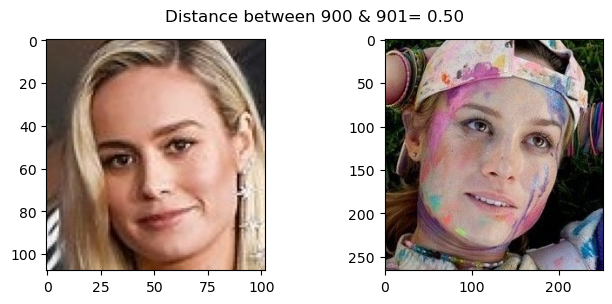

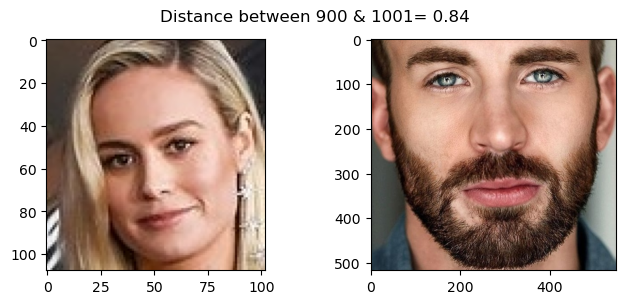

In [64]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(900, 901)
show_pair(900, 1001)

Training the Vgg model:

In [65]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0  
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [66]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (2222,2622)
y_train shape : (2222,)
X_test shape : (278,2622)
y_test shape : (278,)


In [67]:
y_test[0], y_train[988]

('pins_Adriana Lima', 'pins_Chris Pratt')

In [68]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

print(le.classes_)
y_test_encoded = le.transform(y_test)

['pins_Adriana Lima' 'pins_Alex Lawther' 'pins_Alexandra Daddario'
 'pins_Alvaro Morte' 'pins_Amanda Crew' 'pins_Andy Samberg'
 'pins_Anne Hathaway' 'pins_Anthony Mackie' 'pins_Avril Lavigne'
 'pins_Ben Affleck' 'pins_Bill Gates' 'pins_Bobby Morley'
 'pins_Brenton Thwaites' 'pins_Brian J. Smith' 'pins_Brie Larson'
 'pins_Chris Evans' 'pins_Chris Hemsworth' 'pins_Chris Pratt'
 'pins_Christian Bale' 'pins_Cristiano Ronaldo' 'pins_Danielle Panabaker'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Eliza Taylor'
 'pins_Elizabeth Lail' 'pins_Emilia Clarke' 'pins_Emma Stone'
 'pins_Emma Watson' 'pins_Gwyneth Paltrow' 'pins_Henry Cavil'
 'pins_Hugh Jackman' 'pins_Inbar Lavi' 'pins_Irina Shayk'
 'pins_Jake Mcdorman' 'pins_Jason Momoa' 'pins_Jennifer Lawrence'
 'pins_Jeremy Renner' 'pins_Jessica Barden' 'pins_Jimmy Fallon'
 'pins_alycia dabnem carey' 'pins_amber heard' 'pins_barack obama'
 'pins_barbara palvin' 'pins_camila mendes' 'pins_elizabeth olsen'
 'pins_ellen page' 'pins_elon musk' 

In [69]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [ 0  0  0 ... 38 38 38]
y_test_encoded :  [ 0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  3 39
 39 39 39 39  4  4  4  4  4  4 40 40 40 40 40  5  5  5  5  5  5  6  6  6
  6  6  7  7  7  7  7  7  8  8  8  8  8  8 41 41 41 41 41 42 42 42 42 42
 42  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 12 13
 13 13 13 13 14 14 14 14 14 14 43 43 43 43 43 43 15 15 15 15 15 16 16 16
 16 16 16 17 17 17 17 17 18 18 18 18 18 18 19 19 19 19 19 20 20 20 20 20
 20 21 21 21 21 21 22 22 22 22 22 22 23 23 23 23 23 23 24 24 24 24 24 44
 44 44 44 44 44 45 45 45 45 45 46 46 46 46 46 46 25 25 25 25 25 26 26 26
 26 26 26 27 27 27 27 27 47 47 47 47 47 47 48 48 48 48 48 48 28 28 28 28
 28 29 29 29 29 29 29 30 30 30 30 30 31 31 31 31 31 31 32 32 32 32 32 33
 33 33 33 33 33 34 34 34 34 34 49 49 49 49 49 49 35 35 35 35 35 35 36 36
 36 36 36 37 37 37 37 37 37 38 38 38 38 38]


In [70]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [71]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [72]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

y_predict = clf.predict(X_test_pca)
y_predict_encoded = le.inverse_transform(y_predict)

In [73]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

0.9532374100719424

Validating the model:

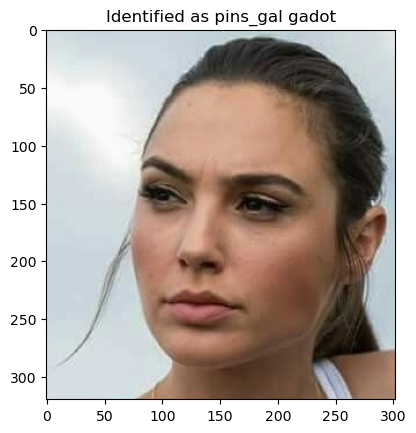

In [76]:
example_idx = 200

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

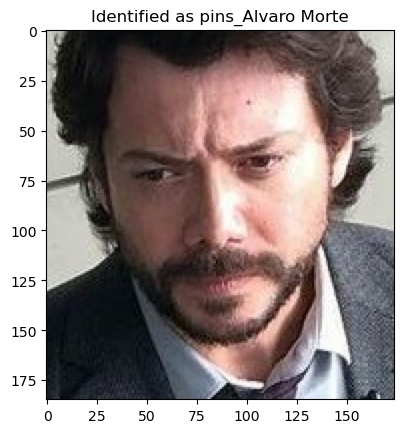

In [79]:
example_idx = 20

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');